# Iteration 2 <br/>*Cross Validation: Right and Wrong*

Jupyter Notebook referenced from my website:
[Software Nirvana: Cross Validation](https://sdiehl28.netlify.com/projects/titanic/titanic02/)

### Goals
1. Add Age to model (requires imputation of missing values)
2. Demonstrate the right and wrong way to perform Cross Validation
3. Compare this model with the previous iteration

### Where We Are
In the first iteration, we created a simple model and showed that the accuracy was better than the null model.  The null model is the model that predicts the predominant class in all cases.

### What's Next
<a href="https://en.wikipedia.org/wiki/Imputation_(statistics)">Imputation on Wikipedia</a>

This notebook will impute the missing values for Age and use Age as an additional attribute for prediction.  We will also check to see if adding the Age variable improved prediction accuracy.

Special attention will be paid to avoid a common beginner's mistake, which is to look at the test data when performing imputation or other preprocessing steps.  The easiest way to ensure there is no "test set leakage", is to use a Pipeline.

### Common Imports and Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

### Previous Model Building Iteration

In [2]:
# read in all the labeled data
all_data = pd.read_csv('../data/train.csv')

# break up the dataframe into X and y
X = all_data.drop('Survived', axis=1)
y = all_data['Survived']

# As before, remove all non-numeric fields and PassengerId
drop_fields = ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'PassengerId']
X = X.drop(drop_fields, axis=1)

X.dtypes

Pclass      int64
Age       float64
SibSp       int64
Parch       int64
Fare      float64
dtype: object

### Cross Validation
[Cross Validation](http://nbviewer.jupyter.org/github/sdiehl28/tutorial-jupyter-notebooks/blob/master/projects/Titanic01.ipynb#crossvalidation) was discussed in the previous iteration.

Here the goal is demonstrate cross validation within the context of imputing missing Age values.  The right way to do this, along with a common wrong way, are discussed.

### Impute Age: Using Cross Validation the Right Way

To a beginner, it can appear that using an Imputer and a Pipeline is a lot of extra work.  Why not just impute the Age prior to cross validation and be done with it?

If you were to look at the ["Kernels"](https://www.kaggle.com/c/titanic/kernels?sortBy=votes&group=everyone&pageSize=20&competitionId=3136) on Kaggle posted for the Titanic dataset, you would see that most people do just that.  But this is bad practice.  It could lead to an estimate of model accuracy that is too high.  Using the test data for any type of data transformation, prior to training your model, is "data leakage".

Scikit Learn correctly uses the mean of the train set as the replacement value for missing values in both the train and test sets.  However this is all done behind the scenes.  The following is exactly the same as the above, but requires much less code.

In [3]:
# imports
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [4]:
# Goal is to show that CV setup correctly differs from CV setup incorrectly
# k_folds should normally be 5 or 10.  It is 2 here to illustrate the goal.
random_state = 121212
k_folds = 2
crossvalidation = StratifiedKFold(n_splits=k_folds, shuffle=True, 
                                  random_state=random_state)

In [5]:
# Use an Imputer and a Pipeline
# Note: Age is the only column in X with null values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='mean')

from sklearn.pipeline import make_pipeline
classifier = make_pipeline(imputer, LogisticRegression())

scores = cross_val_score(classifier, X, y, cv=crossvalidation, 
                         scoring='accuracy', n_jobs=1)

print('Scores :', scores)
print(f'Cross Validated Accuracy: {scores.mean() :.3f}')

Scores : [0.71524664 0.69213483]
Cross Validated Accuracy: 0.704


### Impute Age: Using Cross Validation the Right Way: In Detail
Using cross_val_score hides the key pedagogical point, so don't use it here.

In [6]:
random_state = 121212
k_folds = 2
crossvalidation = StratifiedKFold(n_splits=k_folds, shuffle=True, 
                                  random_state=random_state)

my_scores = np.zeros(k_folds)
i = 0
lr_model = LogisticRegression()
for train_idx, test_idx in crossvalidation.split(X,y):
    
    # train subset
    X_train = X.iloc[train_idx, :].copy()
    y_train = y[train_idx].copy()
    
    # test subset
    X_test = X.iloc[test_idx, :].copy()
    y_test = y[test_idx].copy()
    
    # find the average age on the train set
    train_age_mean = X_train['Age'].mean()
    
    # Replace missing Age values in the train data
    X_train.loc[X_train['Age'].isnull(), 'Age'] = train_age_mean
    
    # Replace missing Age values in the test data
    # Key Point: missing value in Test data set replaced with mean of TRAIN data
    X_test.loc[X_test['Age'].isnull(), 'Age'] = train_age_mean
    
    # fit model on train
    lr_model.fit(X_train, y_train)
    
    # predict using model on test
    predictions = lr_model.predict(X_test)
    
    # evaluate accuracy
    my_scores[i] = accuracy_score(y_test, predictions)
    i += 1
    
# Verify this is exactly the same as using cross_val_score
print("Scores Match: ", (scores == my_scores).all())

Scores Match:  True


### Impute Age: Using Cross Validation The Wrong Way
The wrong, but common way, to do this is to impute age over the entire dataset and then estimate model accuracy using either a train/test split or cross validation.

The purpose of using a train/test split or cross validation is to train the model on one set of data (the training set) and evaluate it on another set (the test data) for which the model building process did not see.  However if you impute age using the entire dataset, you are in effect building the model using the test data. This defeats the purpose of using a train/test split or cross validation and the result is that the estimate of model accuracy could be too high.

In the following, I will show that the wrong way produces different results than the right way.

In [7]:
# Prior to Cross Validation:
#   impute the missing values as the mean of *all* data
# This is "data leakage"!  Don't do this!
# Replace all null Age values with the mean of all Age Values
X.loc[X['Age'].isnull(), 'Age'] = X['Age'].mean()

# Setup: same as above
random_state = 121212
k_folds = 2
crossvalidation = StratifiedKFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_state)

wrong_scores = cross_val_score(LogisticRegression(), X, y, 
                               cv=crossvalidation,
                               scoring='accuracy', n_jobs=1)

# We do *not* get the same scores as above!
print("Scores Match: ", (scores == wrong_scores).all())
print("Scores Diff:  ", np.round(scores.mean() - wrong_scores.mean(), 4))

Scores Match:  False
Scores Diff:   0.0011


Imputing all the missing values, over both the train and test sets, prior to performing cross validation produced different results!  That said, the difference is very small and is not significant for **this particular** dataset.

### Cross Validation The Wrong Way: Discussion
**What was wrong:** Used all data for imputation (did not have hold-out set).

**What may happen:** Estimate of model accuracy may be too high.

**Importance in Practice:  With *imputation*, this is usually not a problem** unless you have a very small amount of data on which to perform the imputation.  In the above, we saw it made almost no difference.

**Importance in Practice:  With *feature selection*, this is usually a very serious problem** which leads to highly inflated values of model accuracy.  Feature selection is the process of determining which variables to include in the model.  If you use the entire dataset, and decide to keep variables based on some statistic of the data, such as correlation to the target variable, then you *must* use a Pipeline or otherwise ensure that you choice of variables to include is determined on a train set and evaluated on a test set.

**Great Explanation and Story by Robert Tibshirani:**
Robert Tibshirani, in the youtube video [Cross Validation: Right and Wrong](https://www.youtube.com/watch?v=S06JpVoNaA0&list=PL5-da3qGB5IA6E6ZNXu7dp89_uv8yocmf), explains the right and wrong way to perform cross validation in detail.  He also presents a wonderful story about a Ph.D. oral dissertation presenter filtering away variables *prior* to performing cross validation and the serious effect it had on his medical research.

### Compute the Score as per Previous Iterations
In order to compare model performance between iterative model improvements, it is necessary to compute the model performance in the same way.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold

# Same as for previous iterations to allow for comparison
k_folds = 10
random_seed=5
crossvalidation = StratifiedKFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

classifier = LogisticRegression()
scores = cross_val_score(classifier, X, y, cv=crossvalidation, 
                         scoring='accuracy', n_jobs=-1)

# save scores for comparison with another iteration
np.save("../data/iter02.data", scores)

print('Scores: ', np.round(scores, 3))
print(f'Cross Validated Accuracy: {scores.mean():.3f}')

Scores:  [0.689 0.7   0.697 0.685 0.742 0.697 0.73  0.652 0.674 0.75 ]
Cross Validated Accuracy: 0.702


### Compare Model Performance with Previous Iteration

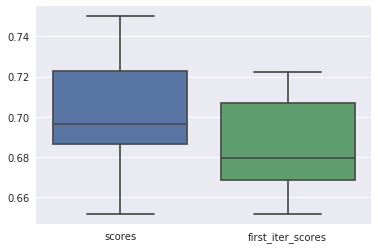

In [9]:
# Read in scores from 1st iteration
first_iter_scores = np.load('../data/iter01.data.npy')

df = pd.DataFrame(data=list(zip(scores, first_iter_scores)),
                  columns=['scores','first_iter_scores'])
sns.boxplot(data=df)

The same random_state was used for each iteration of the model.  This means that of the 10 folds of the model was build and tested on exactly the same data.  This means that we can directly compare the corresponding scores.

In [10]:
diff_scores = scores - first_iter_scores
print(np.round(sorted(diff_scores),3))

[-0.045 -0.022  0.     0.     0.022  0.022  0.022  0.034  0.045  0.067]


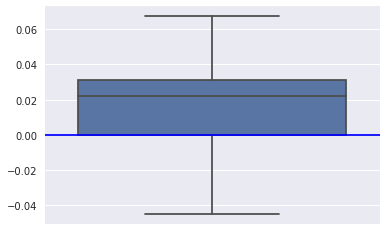

In [11]:
# look at differences
sns.boxplot(y=diff_scores)
plt.axhline(0, color='blue')

In [12]:
# How many times is the new model better?
print(f'New Model wins:  {(diff_scores > 0).sum()}')
print(f'New Model ties:  {(diff_scores == 0).sum()}')
print(f'New Model loses: {(diff_scores < 0).sum()}')

New Model wins:  6
New Model ties:  2
New Model loses: 2


From the above boxplot and paired comparisons of the scores, it appears the new model is slightly better.  The change we made was to impute the missing Age values by their mean value and make use of the Age value in the Logistic Regression Model.  It is reasonable that the model would improve with the addition of the Age variable.

### Model Summary
Model building steps only.

In [13]:
# read in all the labeled data
all_data = pd.read_csv('../data/train.csv')

# break up the dataframe into X and y
X = all_data.drop('Survived', axis=1)
y = all_data['Survived']

# As before, remove all non-numeric fields and PassengerId
drop_fields = ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'PassengerId']
X = X.drop(drop_fields, axis=1)

k_folds = 10
random_seed=5
crossvalidation = StratifiedKFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

imputer = Imputer(strategy='mean')
classifier = make_pipeline(imputer, LogisticRegression())
scores = cross_val_score(classifier, X, y, cv=crossvalidation, 
                         scoring='accuracy', n_jobs=1)

# Use the mean score as the best estimate of model accuracy
print('Scores: ', np.round(scores,3))
print(f'Cross Validated Accuracy: {scores.mean() :.3f}')

Scores:  [0.689 0.7   0.697 0.685 0.742 0.697 0.73  0.652 0.674 0.75 ]
Cross Validated Accuracy: 0.702


In [14]:
# previous model
print(f'Previous Cross Validated Accuracy: {first_iter_scores.mean() :.3f}')

Previous Cross Validated Accuracy: 0.687


### Summary

In this iteration we:
* Added Age to the model
* Imputed the missing Age values
* Showed the right and wrong way to setup for cross validation
* Used Imputation as part of a Pipeline, along with cross_val_score. This improves the quality of the software as it concisely performs cross validation correctly
* slightly improved the model's accuracy from 68.7% to 70.2%